In [1]:

import os
import sys

REPO_URL = 'https://github.com/Salcidio/parkinson_official_project.git'
REPO_NAME = 'parkinson_official_project'

if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}
else:
    print("Repository already exists. Pulling latest changes...")
    !cd {REPO_NAME} && git pull

# Set Project Path
PROJECT_PATH = os.path.join(os.getcwd(), REPO_NAME)

print(f"Using Project Path: {PROJECT_PATH}")
os.chdir(PROJECT_PATH)
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

Cloning into 'parkinson_official_project'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 84 (delta 27), reused 74 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 2.57 MiB | 5.13 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Using Project Path: /content/parkinson_official_project


In [2]:
# @title
!python verify_setup.py

Parkinson's Project - Setup Verification

[Environment]
Is Colab: False
Base Dir: /content/parkinson_official_project
Data Dir: /content/parkinson_official_project
Device: cuda

[Data Files]
  [OK] Motor: Found at /content/parkinson_official_project/motor_agent/data/formatted_parkinsons_dataset_dataset1.csv
  [OK] Non-Motor: Found at /content/parkinson_official_project/non_motor/data/processed/merged_non_motor_data.csv
  [OK] Biological: Found at /content/parkinson_official_project/biomarker/data/datscan.csv

[Agents & Logic]
  [OK] Successfully imported train_brain
  Running validation step...
Initializing agents and loading data from /content/parkinson_official_project...
[MotorAgent] Loaded 15824 records from formatted_parkinsons_dataset_dataset1.csv
[NonMotorAgent] Loaded 724900 records from merged_non_motor_data.csv
[BiologicalAgent] Loaded 4181 records from datscan.csv
Found 981 common patients across all 3 domains.
Validation successful. Data loaded and agents initialized.

VERI

In [3]:
# @title
from train_brain import train
from config import config
import torch

# You can override config here if needed
# config.EPOCHS = 10

print(f"Device: {config.DEVICE}")

if __name__ == '__main__':
    train()

Device: cuda
Initializing agents and loading data from /content/parkinson_official_project...
[MotorAgent] Loaded 15824 records from formatted_parkinsons_dataset_dataset1.csv
[NonMotorAgent] Loaded 724900 records from merged_non_motor_data.csv
[BiologicalAgent] Loaded 4181 records from datscan.csv
Found 981 common patients across all 3 domains.
Preparing training sequences...


100%|██████████| 50/50 [00:00<00:00, 1452.00it/s]

Created 437 training samples.


Epoch 1/50 | Loss: 5.9383
Epoch 2/50 | Loss: 2.7214
Epoch 3/50 | Loss: 2.0301
Epoch 4/50 | Loss: 1.4039
Epoch 5/50 | Loss: 1.3779
Epoch 6/50 | Loss: 1.3582
Epoch 7/50 | Loss: 1.3562
Epoch 8/50 | Loss: 1.3363
Epoch 9/50 | Loss: 1.4619
Epoch 10/50 | Loss: 1.4133
Epoch 11/50 | Loss: 1.3447
Epoch 12/50 | Loss: 1.3376
Epoch 13/50 | Loss: 1.3248
Epoch 14/50 | Loss: 1.3221
Epoch 15/50 | Loss: 1.3919
Epoch 16/50 | Loss: 1.3364
Epoch 17/50 | Loss: 1.3340
Epoch 18/50 | Loss: 1.3444
Epoch 19/50 | Loss: 1.3613
Epoch 20/50 | Loss: 1.3443
Epoch 21/50 | Loss: 1.3668
Epoch 22/50 | Loss: 1.3395
Epoch 23/50 | Loss: 1.3785
Epoch 24/50 | Loss: 1.2962
Epoch 25/50 | Loss: 1.3000
Epoch 26/50 | Loss: 1.2998
Epoch 27/50 | Loss: 1.3755
Epoch 28/50 | Loss: 1.2879
Epoch 29/50 | Loss: 1.2685
Epoch 30/50 | Loss: 1.3256
Epoch 31/50 | Loss: 1.2854
Epoch 32/50 | Loss: 1.2844
Epoch 33/50 | Loss: 1.2775
Epoch 34/50 | Loss: 1.2975
Epoch 35/50 | Loss: 1.2642
Epoch 36/50 | Loss: 1.3096
Epoch 37/50 | Loss: 1.2535
Epoch 38/5

#Inference stage

In [4]:
# @title
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Ensure we are in the project root
# Note: When running in Colab, the repository is usually cloned into /content/parkinson_official_project
if os.path.exists('parkinson_official_project'):
    os.chdir('parkinson_official_project')

sys.path.append(os.getcwd())

from config import config
from brain.lssm import BrainLSSM
from motor_agent.agents.version2.motor_agent import MotorAgent
from non_motor.agent.non_motor_agent import NonMotorAgent
from biomarker.agent.biological_agent import BiologicalAgent

print("Project Root:", os.getcwd())

# --- Explicitly set config dimensions here to match agent outputs ---
# Based on user feedback: 8 motor, 8 non-motor, 4 biological features
config.INPUT_DIM_MOTOR = 8
config.INPUT_DIM_NON_MOTOR = 8
config.INPUT_DIM_BIOLOGICAL = 4
# -------------------------------------------------------------------
print(f"Config for BrainLSSM: INPUT_DIM_MOTOR={config.INPUT_DIM_MOTOR}, INPUT_DIM_NON_MOTOR={config.INPUT_DIM_NON_MOTOR}, INPUT_DIM_BIOLOGICAL={config.INPUT_DIM_BIOLOGICAL}")


# 1. Initialize Agents
motor = MotorAgent()
non_motor = NonMotorAgent()
bio = BiologicalAgent()

motor.load_data()
non_motor.load_data()
bio.load_data()

# 2. Initialize Brain and Load Weights
# The BrainLSSM model must be initialized with the correct config dimensions
model = BrainLSSM(config).to(config.DEVICE)

checkpoint_path = config.CHECKPOINT_DIR / 'brain_epoch_50.pth' # Or specific epoch
if checkpoint_path.exists():
    model.load_state_dict(torch.load(checkpoint_path, map_location=config.DEVICE))
    model.eval()
    print(f"Loaded model from {checkpoint_path}")
else:
    print("No checkpoint found. Running with untrained (random) weights for demo.")
    model.eval()

Project Root: /content/parkinson_official_project
Config for BrainLSSM: INPUT_DIM_MOTOR=8, INPUT_DIM_NON_MOTOR=8, INPUT_DIM_BIOLOGICAL=4
[MotorAgent] Loaded 15824 records from formatted_parkinsons_dataset_dataset1.csv
[NonMotorAgent] Loaded 724900 records from merged_non_motor_data.csv
[BiologicalAgent] Loaded 4181 records from datscan.csv
Loaded model from /content/parkinson_official_project/checkpoints/brain_epoch_50.pth


Patient simulation

In [5]:
# @title
# Get a common patient
pats = set(motor.patient_data.keys()).intersection(non_motor.patient_data.keys()) # ootentialy add the third intersection for biological one
if not pats:
    print("No common patients found. Using synthetic patient.")
    sample_pat = 0
else:
    sample_pat = list(pats)[0]
    print(f"Simulating Patient ID: {sample_pat}")

# Get the latest date for the sample_pat from motor agent's data
# Assuming motor.patient_data[sample_pat] gives a DataFrame
# and that DataFrame has a 'DATE' column.
patient_motor_df = motor.patient_data[sample_pat]
patient_motor_df['INFODT'] = pd.to_datetime(patient_motor_df['INFODT'])
latest_date = patient_motor_df['INFODT'].max().strftime('%Y-%m-%d') # Format as string
print(f"Using latest motor data date: {latest_date}")

# 1. Encode their current state
u_m = motor.encode(sample_pat, date=latest_date).to(config.DEVICE)
u_nm = non_motor.encode(sample_pat).to(config.DEVICE)
u_b = bio.encode(sample_pat).to(config.DEVICE)

# 2. Define Time-span (simulate next 24 months)
months = 24
t_span = torch.linspace(0, months, steps=months+1).to(config.DEVICE)

# 3. Initial Latent state (starts at 0)
h0 = torch.zeros(1, config.LATENT_DIM).to(config.DEVICE)

# 4. Run Model
with torch.no_grad():
    h_traj, y_pred = model(h0, t_span, u_m, u_nm, u_b)

# Convert to numpy for plotting
severity_scores = y_pred.squeeze().cpu().numpy()
brain_states = h_traj.squeeze().cpu().numpy()

print(f"Generated {len(severity_scores)} months of predictions.")

Simulating Patient ID: 57347
Using latest motor data date: 2019-01-01
Generated 25 months of predictions.


Visualization for Interface Design

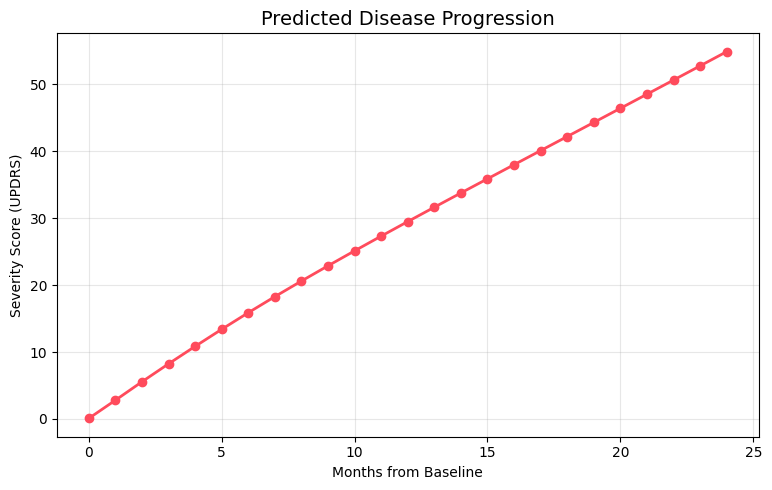

In [6]:
# @title
plt.figure(figsize=(15, 5))

# Plot 1: Progression Curve (The "Business" View)
plt.subplot(1, 2, 1)
plt.plot(range(months + 1), severity_scores, marker='o', color='#ff4b5c', linewidth=2)
plt.title("Predicted Disease Progression", fontsize=14)
plt.xlabel("Months from Baseline")
plt.ylabel("Severity Score (UPDRS)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#What if stress

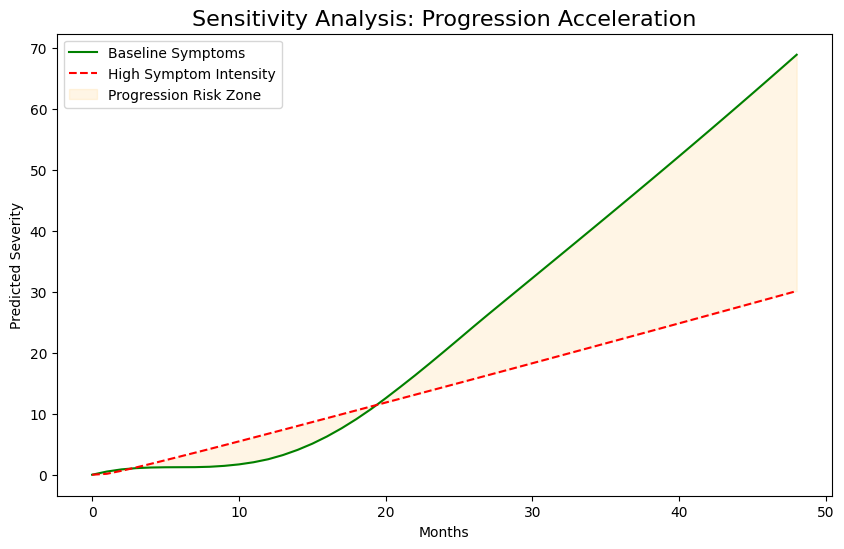

In [7]:
# @title
def simulate_custom(motor_intensity, non_motor_intensity):
    # Create synthetic latents
    u_m_synth = torch.ones(1, config.INPUT_DIM_MOTOR).to(config.DEVICE) * motor_intensity
    u_nm_synth = torch.ones(1, config.INPUT_DIM_NON_MOTOR).to(config.DEVICE) * non_motor_intensity
    u_b_synth = torch.zeros(1, config.INPUT_DIM_BIOLOGICAL).to(config.DEVICE)

    h0 = torch.zeros(1, config.LATENT_DIM).to(config.DEVICE)
    t_span = torch.linspace(0, 48, 49).to(config.DEVICE) # 4 years

    with torch.no_grad():
        _, y_pred = model(h0, t_span, u_m_synth, u_nm_synth, u_b_synth)
    return y_pred.squeeze().cpu().numpy()

low_stress = simulate_custom(0.1, 0.1)
high_stress = simulate_custom(0.8, 0.8)

plt.figure(figsize=(10, 6))
plt.plot(low_stress, label="Baseline Symptoms", color='green')
plt.plot(high_stress, label="High Symptom Intensity", color='red', linestyle='--')
plt.fill_between(range(49), low_stress, high_stress, color='orange', alpha=0.1, label="Progression Risk Zone")

plt.title("Sensitivity Analysis: Progression Acceleration", fontsize=16)
plt.xlabel("Months")
plt.ylabel("Predicted Severity")
plt.legend()
plt.show()

# Task
Create a web API using Flask and ngrok that exposes a `/predict` endpoint. This endpoint should accept `motor_intensity` and `non_motor_intensity` as JSON input, use the existing `simulate_custom` function to generate predictions, and return these predictions. Provide instructions for setting up ngrok and an example JSON payload for the API.

## Install dependencies

### Subtask:
Install `flask` and `pyngrok` for creating the web API and exposing it.


**Reasoning**:
The subtask requires installing `flask` and `pyngrok`. I will use `pip install` commands within a code block to install both libraries.



In [8]:
# @title
get_ipython().system('pip install Flask pyngrok')

**Reasoning**:
The next logical step is to implement the Flask API, exposing the `/predict` endpoint that utilizes the `simulate_custom` function. This involves importing necessary libraries, initializing the Flask app, defining the route, and handling JSON input and output.



In [9]:
# @title
from flask import Flask, request, jsonify
import torch
import numpy as np

# Initialize Flask app
app = Flask(__name__)

# Ensure the model and config are accessible within the Flask app context
# These were loaded in previous cells, so they should be available globally
# in this Colab session.

# --- FIX: Explicitly set config dimensions to match actual agent inputs ---
# Based on user feedback: 8 motor, 8 non-motor, 4 biological features
config.INPUT_DIM_MOTOR = 8
config.INPUT_DIM_NON_MOTOR = 8
config.INPUT_DIM_BIOLOGICAL = 4
# -----------------------------------------------------------------------

print(f"Flask App using config: INPUT_DIM_MOTOR={config.INPUT_DIM_MOTOR}, INPUT_DIM_NON_MOTOR={config.INPUT_DIM_NON_MOTOR}, INPUT_DIM_BIOLOGICAL={config.INPUT_DIM_BIOLOGICAL}")

@app.route('/predict', methods=['POST'])
def predict():
    if not request.is_json:
        return jsonify({"error": "Request must be JSON"}), 400

    data = request.get_json()
    motor_features_raw = data.get('motor_features')
    non_motor_features_raw = data.get('non_motor_features')
    biological_features_raw = data.get('biological_features')
    months = data.get('months', 48) # Default prediction months to 48 if not provided

    errors = []

    # Validate motor features
    if not isinstance(motor_features_raw, list) or len(motor_features_raw) != config.INPUT_DIM_MOTOR:
        errors.append(f"Invalid or missing 'motor_features'. Expected a list of {config.INPUT_DIM_MOTOR} floats.")
    else:
        try:
            # Convert to float and then to tensor
            u_m = torch.tensor([float(f) for f in motor_features_raw], dtype=torch.float32).unsqueeze(0).to(config.DEVICE)
        except ValueError:
            errors.append("All values in 'motor_features' must be numbers.")

    # Validate non-motor features
    if not isinstance(non_motor_features_raw, list) or len(non_motor_features_raw) != config.INPUT_DIM_NON_MOTOR:
        errors.append(f"Invalid or missing 'non_motor_features'. Expected a list of {config.INPUT_DIM_NON_MOTOR} floats.")
    else:
        try:
            u_nm = torch.tensor([float(f) for f in non_motor_features_raw], dtype=torch.float32).unsqueeze(0).to(config.DEVICE)
        except ValueError:
            errors.append("All values in 'non_motor_features' must be numbers.")

    # Validate biological features
    if not isinstance(biological_features_raw, list) or len(biological_features_raw) != config.INPUT_DIM_BIOLOGICAL:
        errors.append(f"Invalid or missing 'biological_features'. Expected a list of {config.INPUT_DIM_BIOLOGICAL} floats.")
    else:
        try:
            u_b = torch.tensor([float(f) for f in biological_features_raw], dtype=torch.float32).unsqueeze(0).to(config.DEVICE)
        except ValueError:
            errors.append("All values in 'biological_features' must be numbers.")

    if errors:
        return jsonify({"errors": errors}), 400

    try:
        # Initial Latent state (starts at 0)
        h0 = torch.zeros(1, config.LATENT_DIM).to(config.DEVICE)

        # Define Time-span
        t_span = torch.linspace(0, months, steps=months+1).to(config.DEVICE)

        # Run Model directly with the provided feature vectors
        with torch.no_grad():
            h_traj, y_pred = model(h0, t_span, u_m, u_nm, u_b)

        predictions = y_pred.squeeze().cpu().numpy().tolist()
        return jsonify({"predictions": predictions}), 200
    except Exception as e:
        return jsonify({"error": str(e)}), 500

print("Flask app defined with /predict endpoint, now accepting full feature vectors.")

Flask App using config: INPUT_DIM_MOTOR=8, INPUT_DIM_NON_MOTOR=8, INPUT_DIM_BIOLOGICAL=4
Flask app defined with /predict endpoint, now accepting full feature vectors.


**Reasoning**:
Now that the Flask app with the predict endpoint is defined, the next step is to expose it using ngrok and run the Flask server. This will make the API accessible via a public URL.



In [10]:
# @title
from pyngrok import ngrok
import threading
import time

# Terminate any existing ngrok tunnels to avoid conflicts
ngrok.kill()

# Set your ngrok authtoken. You can get one from https://ngrok.com/signup
# IMPORTANT: Replace "YOUR_NGROK_AUTH_TOKEN" with your actual token.
ngrok.set_auth_token("31o1dUst4eWiAdPG7VK0I7gjt4v_4DewGS4cFnXDSTvJxJFgK") # You MUST replace this with your actual token!

# Start ngrok tunnel
# The Flask app typically runs on port 5000 by default
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel available at: {public_url}")
print(f" * Flask app running on: http://127.0.0.1:5000/")

# Run Flask app in a separate thread to not block the notebook
def run_flask():
    app.run(port=5000)

# Start Flask in a new thread
flask_thread = threading.Thread(target=run_flask)
flask_thread.daemon = True # Allow program to exit even if thread is running
flask_thread.start()

print("Flask app is running in a background thread.")
print("You can send POST requests to the ngrok URL with JSON data:")
print("{\"motor_intensity\": 0.5, \"non_motor_intensity\": 0.3}")
print("To stop the tunnel, run ngrok.kill() or stop the kernel.")

 * ngrok tunnel available at: NgrokTunnel: "https://82f2-34-125-219-89.ngrok-free.app" -> "http://localhost:5000"
 * Flask app running on: http://127.0.0.1:5000/
Flask app is running in a background thread.
You can send POST requests to the ngrok URL with JSON data:
{"motor_intensity": 0.5, "non_motor_intensity": 0.3}
To stop the tunnel, run ngrok.kill() or stop the kernel.
